<a href="https://colab.research.google.com/github/BehnoodRasti/Unmixing_Tutorial_IEEE_IADF/blob/main/MiSiCNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Blind Unmixing - MiSiCNet

Blind unmixing state-of-the-art deep learning architecture MiSiCNet for both endmembers and abundances estimation.

---

original implementation found at https://github.com/BehnoodRasti/MiSiCNet

Published in

B. Rasti, B. Koirala, P. Scheunders and J. Chanussot, "MiSiCNet: Minimum Simplex Convolutional Network for Deep Hyperspectral Unmixing," in IEEE Transactions on Geoscience and Remote Sensing, vol. 60, pp. 1-15, 2022, Art no. 5522815, doi: 10.1109/TGRS.2022.3146904.

## Imports

1. Clone required github repositories
2. Import Python packages

In [1]:
!git clone https://github.com/BehnoodRasti/Unmixing_Tutorial_IEEE_IADF.git
!git clone https://github.com/BehnoodRasti/MiSiCNet.git

fatal: le chemin de destination 'Unmixing_Tutorial_IEEE_IADF' existe déjà et n'est pas un répertoire vide.
Clonage dans 'MiSiCNet'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (2/2), done.
remote: Total 203 (delta 1), reused 1 (delta 1), pack-reused 201
Réception d'objets: 100% (203/203), 18.78 MiB | 22.25 MiB/s, fait.
Résolution des deltas: 100% (112/112), fait.


In [ ]:
!pip install munkres

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import matplotlib.pyplot as plt

import os

import numpy as np
import torch
import torch.optim
import torch.nn as nn
from tqdm.notebook import tqdm
import scipy.io as sio
import scipy.linalg

from MiSiCNet.UtilityMine import *

In [2]:
from Unmixing_Tutorial_IEEE_IADF.utils.data import HSI
from Unmixing_Tutorial_IEEE_IADF.utils.metrics import MeanSquareError as MSE
from Unmixing_Tutorial_IEEE_IADF.utils.metrics import aRMSE as RMSE
from Unmixing_Tutorial_IEEE_IADF.utils.metrics import SADDegrees as SAD
from Unmixing_Tutorial_IEEE_IADF.utils.metrics import SRE
from Unmixing_Tutorial_IEEE_IADF.utils.aligners import MunkresAbundancesAligner as Aligner
from Unmixing_Tutorial_IEEE_IADF.utils.noises import AdditiveWhiteGaussianNoise as AWGN

## GPU parameters

---

In [3]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

## HSI Data

---

Matlab data keys: dict_keys(['__header__', '__version__', '__globals__', 'Y', 'E', 'A', 'p', 'H', 'W', 'L', 'labels'])
HSI => Sim1
---------------------
224 bands,
105 lines, 105 samples, (11025 pixels),
6 endmembers (['#0', '#1', '#2', '#3', '#4', '#5'])
GlobalMinValue: 0.06107835937291384, GlobalMaxValue: 0.853619396686554

Y shape: (224, 11025)
Desired SNR: 20
Sigmas after normalization: 0.0668153104781061
Sigma mean based on SNR: 0.8550278408177036
Final sigmas value: 0.057128950651659544
(224, 105, 105)


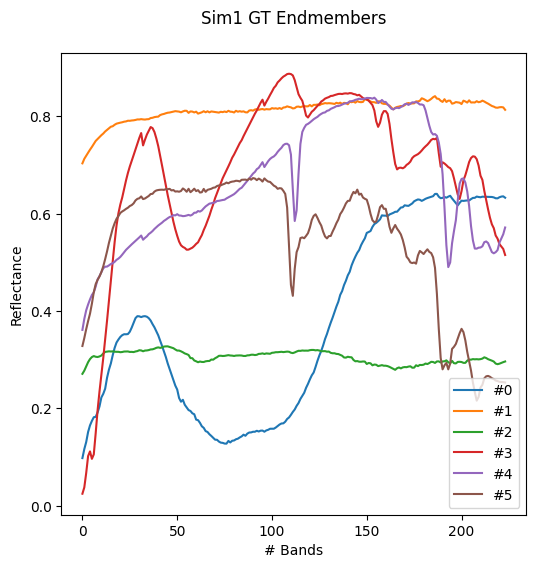

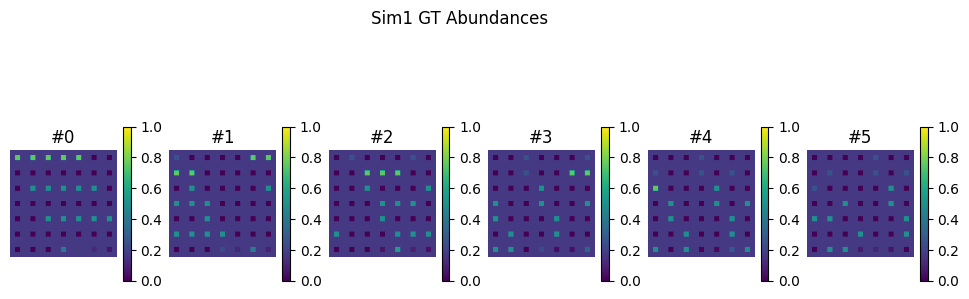

In [10]:
hsi = HSI("Sim1.mat")
print(hsi)

noise = AWGN()

SNR = 20

hsi.Y = noise.fit_transform(hsi.Y, SNR=SNR, seed=0)


Y, _, _ = hsi()
p1, nr1, nc1 = hsi.L, hsi.H, hsi.W
rmax = hsi.p
assert Y.shape == (p1, nr1 * nc1)
img_np_gt = Y.reshape(p1, nr1, nc1)
print(img_np_gt.shape)

hsi.plot_endmembers()
hsi.plot_abundances()

## MiSiCNet

---

1. Data processing
2. Model declaration
3. Training

In [11]:
PLOT = False
tol2=1
save_result=False

for fi in tqdm(range(1)):
    for fj in tqdm(range(tol2)):

        img_noisy_np = img_np_gt
        img_resh=np.reshape(img_noisy_np,(p1,nr1*nc1))
        V, SS, U = scipy.linalg.svd(img_resh, full_matrices=False)
        PC=np.diag(SS)@U

        img_resh_DN=V[:,:rmax]@V[:,:rmax].transpose(1,0)@img_resh
        img_resh_np_clip=np.clip(img_resh_DN, 0, 1)
        II,III = Endmember_extract(img_resh_np_clip,rmax)
        E_np1=img_resh_np_clip[:,II]


        INPUT = 'noise' 
        pad = 'reflection'
        need_bias=True
        OPT_OVER = 'net' 
        
        # 
        LR1 = 0.001
        show_every = 100
        exp_weight=0.99
        
        num_iter1 = 8000 # Change this to 4000 and 6000 and report the results. 
        #num_iter1 = 500
        nf=256 # This is the number filters; Change this to 128 and 68 and report aRMSE and SAD
        #lambMV=100 # This is the MV regularization parameter. Change this to  .1, 1, and 10 and report aRMSE and SAD
        lambMV=0.1
        input_depth =  img_noisy_np.shape[0]
        class CAE_EndEst(nn.Module):
            def __init__(self):
                super(CAE_EndEst, self).__init__()
                self.conv1 = nn.Sequential(
                    conv(input_depth, nf,3,1,bias=need_bias, pad=pad),
                    nn.BatchNorm2d(nf,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    nn.LeakyReLU(0.1, inplace=True),
                )
                self.conv2 = nn.Sequential(
                    conv(nf, nf,3,1,bias=need_bias, pad=pad),
                    nn.BatchNorm2d(nf,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    nn.LeakyReLU(0.1, inplace=True),
                )
                self.conv3 = nn.Sequential(
                    conv(input_depth, 4, 1,1,bias=need_bias, pad=pad),
                    nn.BatchNorm2d(4,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    nn.LeakyReLU(0.1, inplace=True),
                )
                self.dconv2 = nn.Sequential(
                    nn.Upsample(scale_factor=1),
                    conv(260, nf, 3,1,bias=need_bias, pad=pad),
                    nn.BatchNorm2d(nf,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    nn.LeakyReLU(0.1, inplace=True),
                )
        
                self.dconv3 = nn.Sequential(
                    nn.Upsample(scale_factor=1),
                    conv(nf, rmax, 3,1,bias=need_bias, pad=pad),
                    nn.BatchNorm2d(rmax,eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    nn.Softmax(),
                )
                self.dconv4 = nn.Sequential(
                    nn.Linear(rmax, p1,bias=False),
                )
            def forward(self, x):
                x1 = self.conv3(x)
                x = self.conv1(x)
                x = torch.cat([x,x1], 1)
                x = self.dconv2(x)
                x2 = self.dconv3(x)
                x3 = torch.transpose(x2.view((rmax,nr1*nc1)),0,1)
                x3 = self.dconv4(x3)
                return x2,x3

        net1 = CAE_EndEst()
        net1.cuda()
        
        # Loss
        def my_loss(target, End2, lamb, out_):
            loss1 = 0.5*torch.norm((out_.transpose(1,0).view(1,p1,nr1,nc1) - target), 'fro')**2
            O = torch.mean(target.view(p1,nr1*nc1),1).type(dtype).view(p1,1)
            B = torch.from_numpy(np.identity(rmax)).type(dtype)
            loss2 = torch.norm(torch.mm(End2,B.view((rmax,rmax)))-O, 'fro')**2
            return loss1+lamb*loss2
        img_noisy_torch = torch.from_numpy(img_resh_DN).view(1,p1,nr1,nc1).type(dtype)
        net_input1 = get_noise(input_depth, INPUT,
            (img_noisy_np.shape[1], img_noisy_np.shape[2])).type(dtype).detach()
        E_torch = torch.from_numpy(E_np1).type(dtype)
  
        out_avg = True
        
        i = 0
        def closure1():
            
            global i, out_LR_np, out_avg, out_avg_np, Eest,lambMV
            
            out_LR,out_spec = net1(net_input1)
            # Smoothing
            if out_avg is None:
                out_avg = out_LR.detach()
            else:
                out_avg = out_avg * exp_weight + out_LR.detach() * (1 - exp_weight)
 
            total_loss = my_loss(img_noisy_torch, net1.dconv4[0].weight,lambMV,out_spec)
            total_loss.backward()
         
          

            if  PLOT and i % show_every == 0:
                out_LR_np = out_LR.detach().cpu().squeeze().numpy()
                out_avg_np = out_avg.detach().cpu().squeeze().numpy()
                out_LR_np = np.clip(out_LR_np, 0, 1)
                out_avg_np = np.clip(out_avg_np, 0, 1)    
                f, ((ax1, ax2)) = plt.subplots(1, 2, sharey=True, figsize=(10,10))
                ax1.imshow(np.stack((out_LR_np[2,:,:],out_LR_np[1,:,:],out_LR_np[0,:,:]),2))
                ax2.imshow(np.stack((out_avg_np[2,:,:],out_avg_np[1,:,:],out_avg_np[0,:,:]),2))
                plt.show()                 
            i += 1       
            return total_loss
        net1.dconv4[0].weight=torch.nn.Parameter(E_torch.view(p1,rmax))       
        p11 = get_params(OPT_OVER, net1, net_input1)
        optimizer = torch.optim.Adam(p11, lr=LR1, betas=(0.9, 0.999), eps=1e-8,
                  weight_decay= 0, amsgrad=False)
        for j in tqdm(range(num_iter1)):
                optimizer.zero_grad()
                closure1()  
                optimizer.step()
                net1.dconv4[0].weight.data[net1.dconv4[0].weight <= 0] = 0
                net1.dconv4[0].weight.data[net1.dconv4[0].weight >= 1] = 1
                if j>0:
                  Eest=net1.dconv4[0].weight.detach().cpu().squeeze().numpy()
                  if PLOT and j % show_every== 0: 
                    plt.plot(Eest)
                    plt.show()
                  
        out_avg_np = out_avg.detach().cpu().squeeze().numpy()

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

## Qualitative results

---

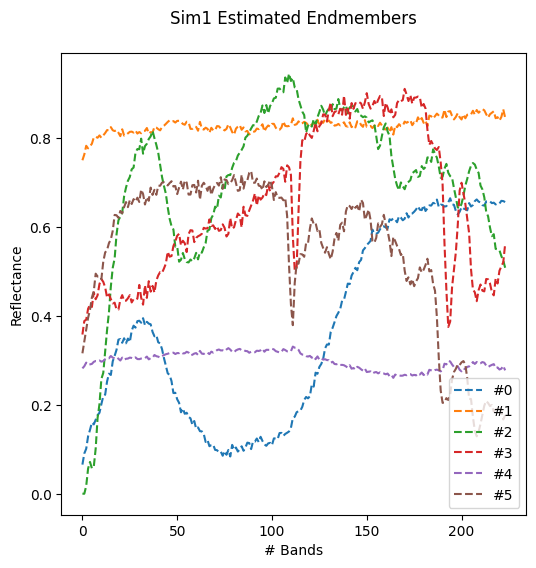

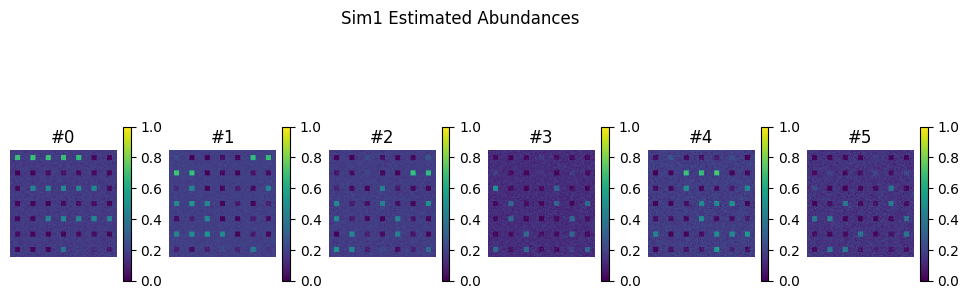

In [12]:
E0 = Eest
A0 = out_avg_np.reshape(hsi.p, hsi.N)

# Plot results
hsi.plot_endmembers(E0=E0)
hsi.plot_abundances(A0=A0)

## Endmembers alignment

---

At this stage we need to align the endmembers and the abundances to compute the RMSE and SAD metrics.

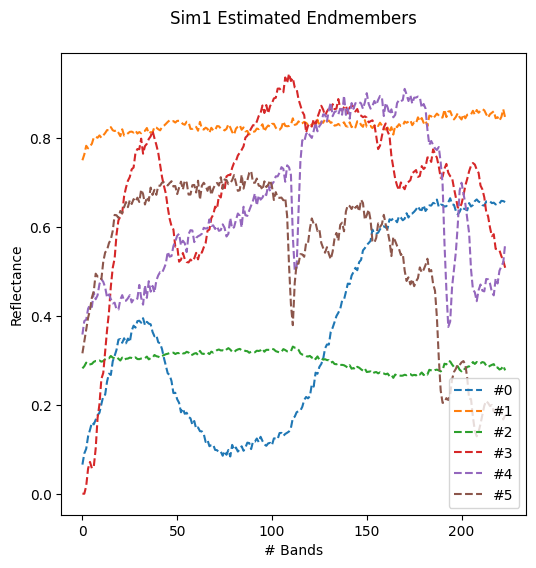

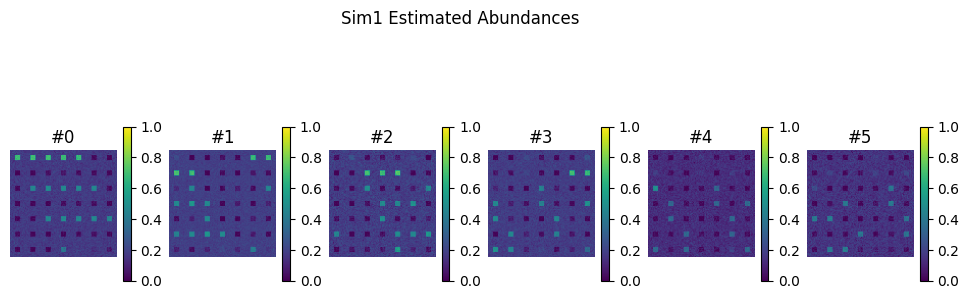

In [13]:
# Select a criterion to perform alignment
criterion = MSE()

# Select an aligner to perform alignment
aligner = Aligner(hsi=hsi, criterion=criterion)

A1 = aligner.fit_transform(A0)
E1 = aligner.transform_endmembers(E0)

# Plot alignment
hsi.plot_endmembers(E0=E1)
hsi.plot_abundances(A0=A1)

## Quantitative results

---

We are now in shape to compute the abundances RMSE and endmembers SAD.

In [14]:
# Instantiate metrics
rmse = RMSE()
sad = SAD()
sre = SRE()

# Compute final numbers
print(f"RMSE => {rmse(hsi.A, A1):.2f}")
print(f"SAD => {sad(hsi.E, E1):.2f}")
print(f"SRE => {sre(hsi.A, A1):.2f}")

RMSE => 3.86
SAD => 2.67
SRE => 13.54


### Results for each material

In [ ]:
# Change the following line if you change dataset!
# Either comment out or describe each material name.
hsi.labels = ["Road", "Tree", "Roof", "Water"]
assert len(hsi.labels) == hsi.p

for ii, label in enumerate(hsi.labels):
    a, ahat = hsi.A[ii], A1[ii]
    print(f"RMSE ({label}) => {rmse(a, ahat):.2f}")

print("-" * 15)

for ii, label in enumerate(hsi.labels):
    e, ehat = hsi.E[:, ii][:, None], E1[:, ii][:, None]
    print(f"SAD ({label}) => {sad(e, ehat):.2f}")